Processing file: E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MYD21A1D\Filtered_Data\2-Jul.csv
Columns in file E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MYD21A1D\Filtered_Data\2-Jul.csv: ['system:index', 'lst_1km', 'lst_1km_scaled', 'view_angle', 'view_angle_scaled', 'view_time', 'view_time_scaled', 'date', 'label', '.geo', 'year', 'month', 'day', 'time', 'datetime']
Processing file: E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MYD21A1D\Filtered_Data\AMD2.csv
Columns in file E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MYD21A1D\Filtered_Data\AMD2.csv: ['system:index', 'lst_1km', 'lst_1km_scaled', 'view_angle', 'view_angle_scaled', 'view_time', 'view_time_scaled', 'date', 'label', '.geo', 'year', 'month', 'day', 'time', 'datetime']
Processing file: E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MYD21A1D\Filtered_Data\ANV2.csv
Columns in file E:\all folders\STUDIES\UZH\master thesis\MODIS DATA

C:\Users\Grandiose\AppData\Local\Temp\ipykernel_14800\2527909615.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


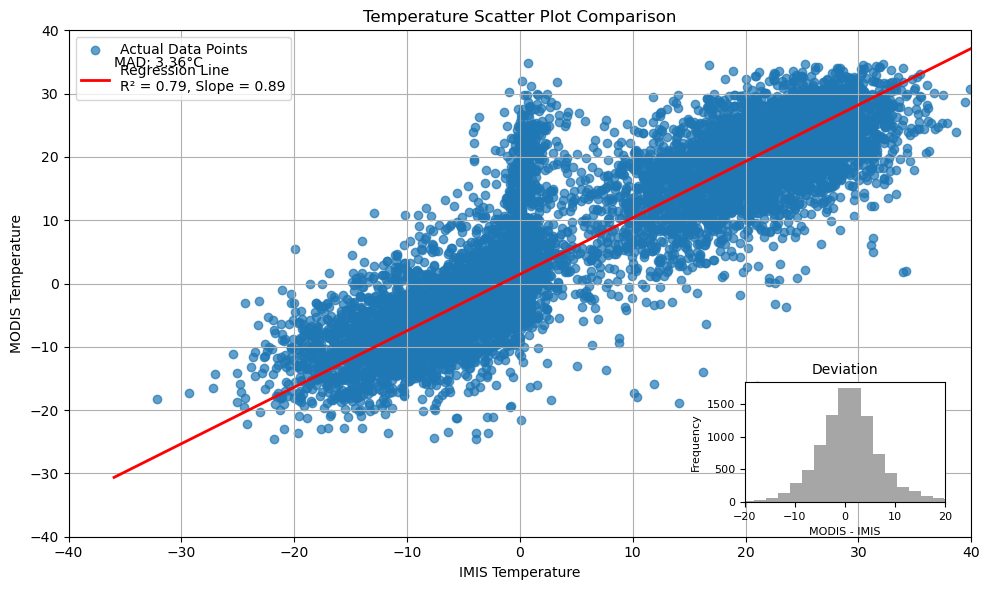

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import TheilSenRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import glob
import os

# Define the paths to the directories containing the MODIS and IMIS temperature files
modis_path = r'E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MYD21A1D\Filtered_Data'
imis_path = r'E:\all folders\STUDIES\UZH\master thesis\IMIS data\new data\new processed data\TSS_30MIN_MEAN_files\Stations covering 2000till 2023'

def load_and_prepare_data(path, temp_column):
    """Load and prepare temperature data from CSV files in a given path."""
    files = glob.glob(os.path.join(path, '*.csv'))
    data_list = []
    
    for file in files:
        try:
            print(f"Processing file: {file}")
            
            df = pd.read_csv(file)
            print(f"Columns in file {file}: {df.columns.tolist()}")
            
            if temp_column in df.columns:
                if 'datetime' in df.columns:
                    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
                elif all(col in df.columns for col in ['year', 'month', 'day', 'time']):
                    df['datetime'] = pd.to_datetime(
                        df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df['time'],
                        errors='coerce'
                    )
                else:
                    print(f"Neither 'datetime' column nor 'year', 'month', 'day', 'time' columns found in file {file}")
                    continue

                df.dropna(subset=['datetime'], inplace=True)
                df = df[['datetime', temp_column]]
                df['source'] = os.path.basename(file)
                data_list.append(df)
            else:
                print(f"Column {temp_column} not found in file {file}")
        except Exception as e:
            print(f"Failed to process file {file}: {e}")
    
    return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()

# Load temperature data
modis_df = load_and_prepare_data(modis_path, 'lst_1km_scaled')
imis_df = load_and_prepare_data(imis_path, 'TSS_30MIN_MEAN')

# Check if the dataframes are empty
if modis_df.empty or imis_df.empty:
    raise ValueError("One or both of the datasets are empty or did not contain the required columns.")

# Merge data on 'datetime' column
merged_df = pd.merge(modis_df, imis_df, on='datetime', suffixes=('_modis', '_imis'))

# Drop rows with NaN values
merged_df.dropna(subset=['lst_1km_scaled', 'TSS_30MIN_MEAN'], inplace=True)

# Sample a subset of the data to avoid memory issues
sampled_df = merged_df.sample(n=10000, random_state=1)

# Prepare data for plotting
X = sampled_df['TSS_30MIN_MEAN'].values.reshape(-1, 1)  # IMIS temperatures
y = sampled_df['lst_1km_scaled'].values  # MODIS temperatures

# Fit the robust regression model
reg = TheilSenRegressor().fit(X, y)
y_pred = reg.predict(X)

# Calculate R² and slope
r2 = r2_score(y, y_pred)
slope = reg.coef_[0]

# Calculate Accuracy (Mean Absolute Difference)
mad = np.median(np.abs(y - y_pred))

# Calculate Precision (Standard Deviation of Deviation)
deviation = y - sampled_df['TSS_30MIN_MEAN'].values
precision = np.std(deviation)

# Create the scatter plot with the regression line
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X, y, alpha=0.7, label='Actual Data Points')
# Determine the x-axis range
x_min, x_max = ax.get_xlim()

# Create a range of x values covering the entire axis
x_range = np.linspace(x_min, x_max, 100)

# Calculate the corresponding y values based on the regression line equation
y_range = reg.predict(x_range.reshape(-1, 1))

# Plot the regression line over the entire x-axis range
ax.plot(x_range, y_range, color='red', linewidth=2, label=f'Regression Line\nR² = {r2:.2f}, Slope = {slope:.2f}')


# Set the axis limits to a specific range if needed
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)

# Set titles and labels
ax.set_title('Temperature Scatter Plot Comparison')
ax.set_xlabel('IMIS Temperature')
ax.set_ylabel('MODIS Temperature')
ax.grid(True)
ax.legend()

# Calculate the deviation between MODIS and IMIS temperatures
deviation = y - sampled_df['TSS_30MIN_MEAN'].values

# Create a secondary axes for the histogram (inset plot)
ax_inset = plt.axes([0.75, 0.155, 0.2, 0.2])  # Position of the inset: [left, bottom, width, height]
ax_inset.hist(deviation, bins=30, color='gray', alpha=0.7)
ax_inset.set_title('Deviation', fontsize=10)
ax_inset.set_xlabel('MODIS - IMIS', fontsize=8)
ax_inset.set_ylabel('Frequency', fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)

# Set x-axis limits for the histogram
ax_inset.set_xlim(-20, 20)


# Add accuracy and precision as text in the main plot
accuracy_text = f"MAD: {mad:.2f}°C"

plt.text(0.05, 0.95, accuracy_text, transform=ax.transAxes, fontsize=10, verticalalignment='top')


plt.tight_layout()
plt.show()

C:\Users\Grandiose\AppData\Local\Temp\ipykernel_14800\1811339607.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


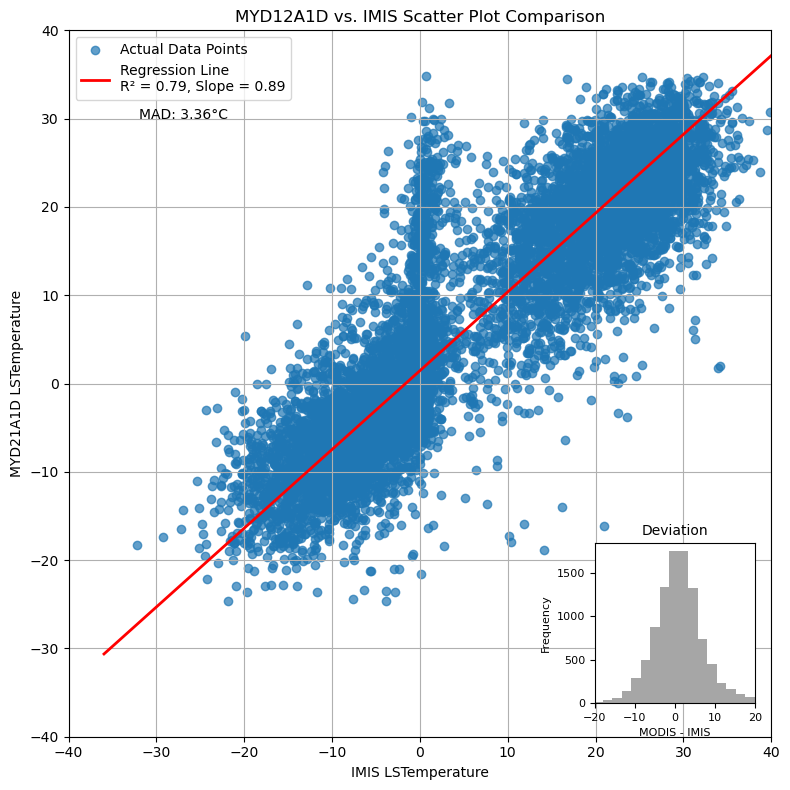

In [7]:
# Create the scatter plot with the regression line
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X, y, alpha=0.7, label='Actual Data Points')
# Determine the x-axis range
x_min, x_max = ax.get_xlim()

# Create a range of x values covering the entire axis
x_range = np.linspace(x_min, x_max, 100)

# Calculate the corresponding y values based on the regression line equation
y_range = reg.predict(x_range.reshape(-1, 1))

# Plot the regression line over the entire x-axis range
ax.plot(x_range, y_range, color='red', linewidth=2, label=f'Regression Line\nR² = {r2:.2f}, Slope = {slope:.2f}')

# Set the axis limits to a specific range if needed
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)

# Set titles and labels
ax.set_title('MYD12A1D vs. IMIS Scatter Plot Comparison')
ax.set_xlabel('IMIS LSTemperature')
ax.set_ylabel('MYD21A1D LSTemperature')
ax.grid(True)
ax.legend()

# Calculate the deviation between MODIS and IMIS temperatures
deviation = y - sampled_df['TSS_30MIN_MEAN'].values

# Create a secondary axes for the histogram (inset plot)
ax_inset = plt.axes([0.75, 0.115, 0.2, 0.2])  # Position of the inset: [left, bottom, width, height]
ax_inset.hist(deviation, bins=30, color='gray', alpha=0.7)
ax_inset.set_title('Deviation', fontsize=10)
ax_inset.set_xlabel('MODIS - IMIS', fontsize=8)
ax_inset.set_ylabel('Frequency', fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)

# Set x-axis limits for the histogram
ax_inset.set_xlim(-20, 20)

# Add accuracy and precision as text in the main plot
accuracy_text = f"MAD: {mad:.2f}°C"

plt.text(0.1, 0.89, accuracy_text, transform=ax.transAxes, fontsize=10, verticalalignment='top')


plt.tight_layout()
plt.show()

Skipping file mean_temperatures.csv as it does not contain the required columns.
Skipping file mean_temperature_trends_by_hour.csv as it does not contain the required columns.
Skipping file Stations trends per hour.csv as it does not contain the required columns.
Skipping file station_slopes.csv as it does not contain the required columns.
Error processing file table_image_MODIS.png: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
Skipping file mean_temperatures.csv as it does not contain the required columns.
Skipping file station_slopes.csv as it does not contain the required columns.


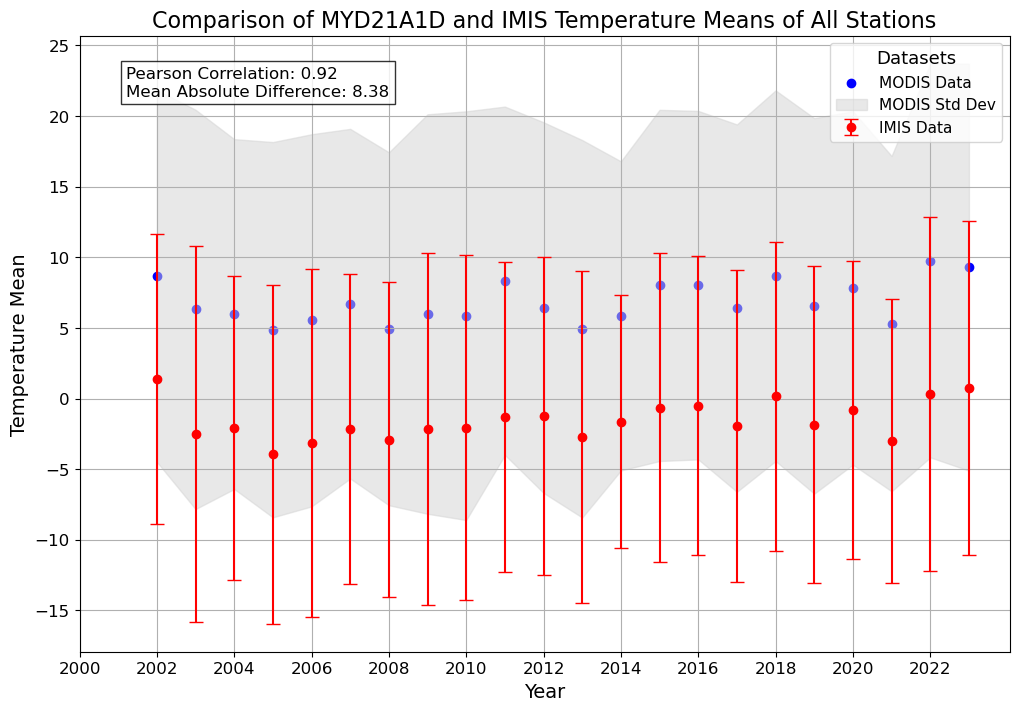

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Function to process the folder and calculate yearly stats
def process_folder(folder_path, data_column, is_imis=False):
    all_stats = []
    
    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Skip directories and only process files
        if os.path.isdir(file_path):
            continue

        try:
            df = pd.read_csv(file_path)
            
            # Normalize column names to lowercase
            df.columns = [col.lower() for col in df.columns]
            
            # Check if the required columns are present
            required_columns = ['year', 'month', 'day', 'time']
            if not all(col in df.columns for col in required_columns) or (not is_imis and data_column.lower() not in df.columns):
                print(f"Skipping file {filename} as it does not contain the required columns.")
                continue
            
            # Create a 'datetime' column from year, month, day, time
            df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'time']].astype(str).agg('-'.join, axis=1), errors='coerce')
            df['Year'] = df['year']
            
            # Ensure the temperature data is numeric
            df[data_column.lower()] = pd.to_numeric(df[data_column.lower()], errors='coerce')
            
            # Group by year and calculate mean and standard deviation for each year
            yearly_stats = df.groupby('Year').agg({data_column.lower(): ['mean', 'std']}).reset_index()
            yearly_stats.columns = ['Year', 'Mean', 'Std']  # Rename columns
            all_stats.append(yearly_stats)
        
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
            continue

    # Combine all stats from different files into a single DataFrame
    if all_stats:
        return pd.concat(all_stats).groupby('Year').agg({'Mean': 'mean', 'Std': 'mean'}).reset_index()
    else:
        print("No valid data found in the folder.")
        return pd.DataFrame(columns=['Year', 'Mean', 'Std'])

# Paths to the MODIS and IMIS data folders
modis_folder = r'E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MYD21A1D\Filtered_Data'
imis_folder = r'E:\all folders\STUDIES\UZH\master thesis\IMIS data\new data\new processed data\TSS_30MIN_MEAN_files\Stations covering 2000till 2023\analysis\interporelated data\NEW aqua day time\Filtered_Data'

# Process both MODIS and IMIS folders
modis_stats = process_folder(modis_folder, 'LST_1KM_scaled')
imis_stats = process_folder(imis_folder, 'TSS_30MIN_MEAN', is_imis=True)

# Merge the two datasets on 'Year'
if not modis_stats.empty and not imis_stats.empty:
    merged_stats = pd.merge(modis_stats, imis_stats, on='Year', suffixes=('_MODIS', '_IMIS'))
    
    # Calculate compatibility metrics
    pearson_corr, _ = pearsonr(merged_stats['Mean_MODIS'], merged_stats['Mean_IMIS'])
    mean_absolute_difference = (merged_stats['Mean_MODIS'] - merged_stats['Mean_IMIS']).abs().mean()

    # Plotting the merged data
    plt.figure(figsize=(12, 8))

    # MODIS Data
    plt.scatter(merged_stats['Year'], merged_stats['Mean_MODIS'], color='blue', label='MODIS Data')
    plt.fill_between(merged_stats['Year'], merged_stats['Mean_MODIS'] - merged_stats['Std_MODIS'], merged_stats['Mean_MODIS'] + merged_stats['Std_MODIS'], color='lightgray', label='MODIS Std Dev', alpha=0.5)

    # IMIS Data
    plt.errorbar(merged_stats['Year'], merged_stats['Mean_IMIS'], yerr=merged_stats['Std_IMIS'], fmt='o', color='red', label='IMIS Data', capsize=5)

    # Add labels, title, legend, grid, and metrics text
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Temperature Mean', fontsize=14)
    plt.title('Comparison of MYD21A1D and IMIS Temperature Means of All Stations', fontsize=16)
    plt.legend(title='Datasets', title_fontsize='13', fontsize='11')
    plt.grid(True)
    plt.xticks(range(2000, 2024, 2), fontsize=12)
    plt.yticks(fontsize=12)

    # Add compatibility metrics to the plot
    plt.text(0.05, 0.95, f"Pearson Correlation: {pearson_corr:.2f}\nMean Absolute Difference: {mean_absolute_difference:.2f}", 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    # Show plot
    plt.show()
else:
    print("Insufficient data for analysis.")